In [1]:
%matplotlib inline
import numpy as np
from scipy import optimize, stats
import matplotlib.pyplot as plt

In [2]:
%load_ext Cython

In [3]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport pow

cdef double pos(double x):
    if x > 0:
        return x
    else:
        return 0.0

cdef double holding(double q, double x, double[:] d, double a, double h):
    cdef total_holding = 0
    cdef n_held = 0
    cdef cum_demand = 0
    for i in range(len(d)):
        cum_demand += d[i]
        n_held = pos(q - pos(cum_demand - x))
        if n_held <= 0:
            break
        else:
            total_holding += pow(a, i)*h*n_held
    return total_holding
        
cdef double penalty(double q, double x, double d, double p):
    return p*pos(d - x - q)
    
def loss_max(q, x, d, a, p, h):
    return max(holding(q, x, d, a, h), penalty(q, x, d[0], p))

def loss_root(q, x, d, a, p, h):
    return holding(q, x, d, a, h) - penalty(q, x, d[0], p)

In [ ]:
import numpy as np
from scipy import stats, optimize

def myopic_backorder(q, x, d_mean, d_std, p_cost):
    dist = stats.norm(d_mean[0], d_std[0])
    penalty = dist.expect(lambda u: p_cost*(u - x - q), lb=(x+q))
    return penalty

def der_myopic_backorder(q, x, d_mean, d_std, p_cost):
    dist = stats.norm(d_mean[0], d_std[0])
    der_penalty = p_cost*(1 - dist.cdf(x + q))
    return der_penalty

def horizon_holding(q, x, d_mean, d_std, h_cost, tol=1e-6):
    holding = 0
    for mean, var in zip(np.cumsum(d_mean), np.cumsum(np.square(d_std))):
        dist = stats.norm(mean, np.sqrt(var))
        held = dist.expect(lambda u: h_cost*(x + q - u), lb=x, ub=(x+q))
        if held < tol:
            break
        holding += held
    return holding

def der_horizon_holding(q, x, d_mean, d_std, h_cost, tol=1e-6):
    der_holding = 0
    for mean, var in zip(np.cumsum(d_mean), np.cumsum(np.square(d_std))):
        dist = stats.norm(mean, np.sqrt(var))
        held = dist.cdf(x + q) - dist.cdf(x)
        der_holding += h_cost*held
    return der_holding

def sicp_root(q, x, d_mean, d_std, h, p):
    return holding_loss(q, x, d_mean, d_std, h) \
        - backorder_loss(q, x, d_mean, d_std, p)

def sicp_root_der(q, x, d_mean, d_std, h, p):
    return der_holding_loss(q, x, d_mean, d_std, h) \
        + der_backorder_loss(q, x, d_mean, d_std, p)

def sicp_max(q, x, d_mean, d_std, h, p):
    return max(holding_loss(q, x, d_mean, d_std, h),
               backorder_loss(q, x, d_mean, d_std, p))


## Scenario 1: Stochastic Inventory Control Problem with IID Normal Demand

In this scenario, each period's demand is drawn from the same normal distribution. This is a base-case for the remaining scenarios. The costs will be computed analytically, and simulated. 

In [4]:
mu, std = 50, 5
h, p = 1, 5
x = 0
horizon = 50
max_q = 100
n_reps = 100
seed = 5000
np.random.seed(seed)

mu = np.repeat(mu, horizon)
std = np.repeat(std, horizon)

In [7]:
q0 = max_q
q_star = optimize.newton(sicp_root, q0, 
                         args = (x, mu, std, h, p), 
                         fprime = sicp_root_der)

q_grid = np.arange(0, max_q)
l_grid = np.zeros(max_q)
m_grid = np.zeros(max_q)
s_grid = np.zeros((max_q, n_reps))
for i, q in enumerate(q_grid):
    l_grid[i] = sicp_root(q, 0, mu, std, h, p)
    m_grid[i] = sicp_max(q, 0, mu, std, h, p)
    for j in range(n_reps):
        d = np.random.normal(mu, std, size=horizon)
        s_grid[i, j] = loss_max(q, x, d, 1, p, h)

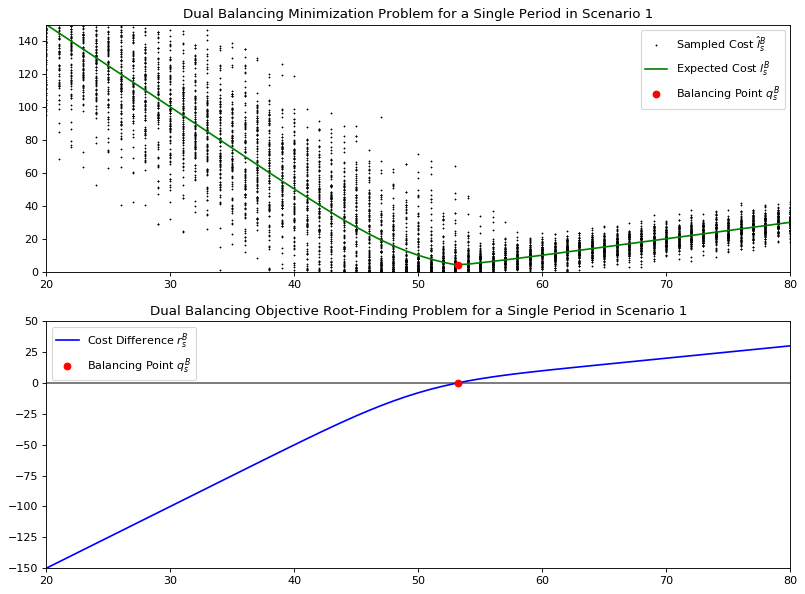

In [9]:
q_grid_flat = np.tile(q_grid, n_reps)
s_grid_flat = s_grid.T.flatten()

f, axes = plt.subplots(2, 1, figsize=(12, 9), dpi=80)
axes[0].set_title("Dual Balancing Minimization Problem for a Single Period in Scenario 1")
axes[0].plot(q_grid_flat, s_grid_flat, "kx", ms=1, label="Sampled Cost $\hat{l}_s^B$")
axes[0].plot(q_grid, m_grid, "g", label="Expected Cost $l_s^B$")
axes[0].plot(q_star, sicp_max(q_star, x, mu, std, h, p), "ro", label="Balancing Point $q_s^B$");
axes[0].legend()
axes[0].set_ylim(0, 150)
axes[0].set_xlim(20, 80)
axes[1].set_title("Dual Balancing Objective Root-Finding Problem for a Single Period in Scenario 1")
axes[1].axhline(y=0, c="k", alpha=.6)
axes[1].plot(q_grid, l_grid, "b", label="Cost Difference $r_s^B$");
axes[1].plot(q_star, sicp_root(q_star, x, mu, std, h, p), "ro", label="Balancing Point $q_s^B$");
axes[1].legend()
axes[1].set_ylim(-150, 50)
axes[1].set_xlim(20, 80);
f.savefig("scenario_1.png")

## Scenario 2: Lot Sizing Problem with IID Normal Demand